In [2]:
import pymongo
import dotenv
import os
from guardrail import Guardrail
import pandas as pd

dotenv.load_dotenv()

True

In [3]:
atlas = pymongo.MongoClient(os.environ["MONGODB_URI"])
embedding_collection = atlas.get_database("db").get_collection(
    "embeddings"
)

In [4]:
test_dataset = pd.read_csv("./benchmark/spml_prompt_injection.csv")


In [5]:
guardrail_validation = Guardrail(
    vector_store=embedding_collection,
    similarity_upper_bound=0.4,
    anomaly_upper_bound=0.05,
    entropy_upper_bound=5.8,
)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Inicializa variáveis
y_true = []  # Valores reais (0 = normal, 1 = prompt injection)
y_pred = []  # Predição do framework (0 = permitido, 1 = bloqueado)
success_events = {}
error_events = {}

iterations = []  
simulation = test_dataset[:300:2]  # Ajuste para o tamanho desejado

# Loop de validação
for index, row in simulation.iterrows():
    should_block = guardrail_validation.should_block(row["User Prompt"])
    predicted_block = int(should_block.get("blocked"))  # 1 se bloqueado, 0 se não
    actual_label = int(row["Prompt injection"])  # 1 se prompt injection, 0 se normal
    
    y_true.append(actual_label)
    y_pred.append(predicted_block)
    
    # Registro de eventos
    if predicted_block == actual_label:
        success_events[should_block.get("reason")] = success_events.get(should_block.get("reason"), 0) + 1
    else:
        error_events[should_block.get("reason")] = error_events.get(should_block.get("reason"), 0) + 1

    iterations.append(index)

# Calcula métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_true, y_pred)

# Exibe métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Acurácia: 0.9667
Precisão: 0.9618
Revocação (Recall): 1.0000
F1-Score: 0.9805


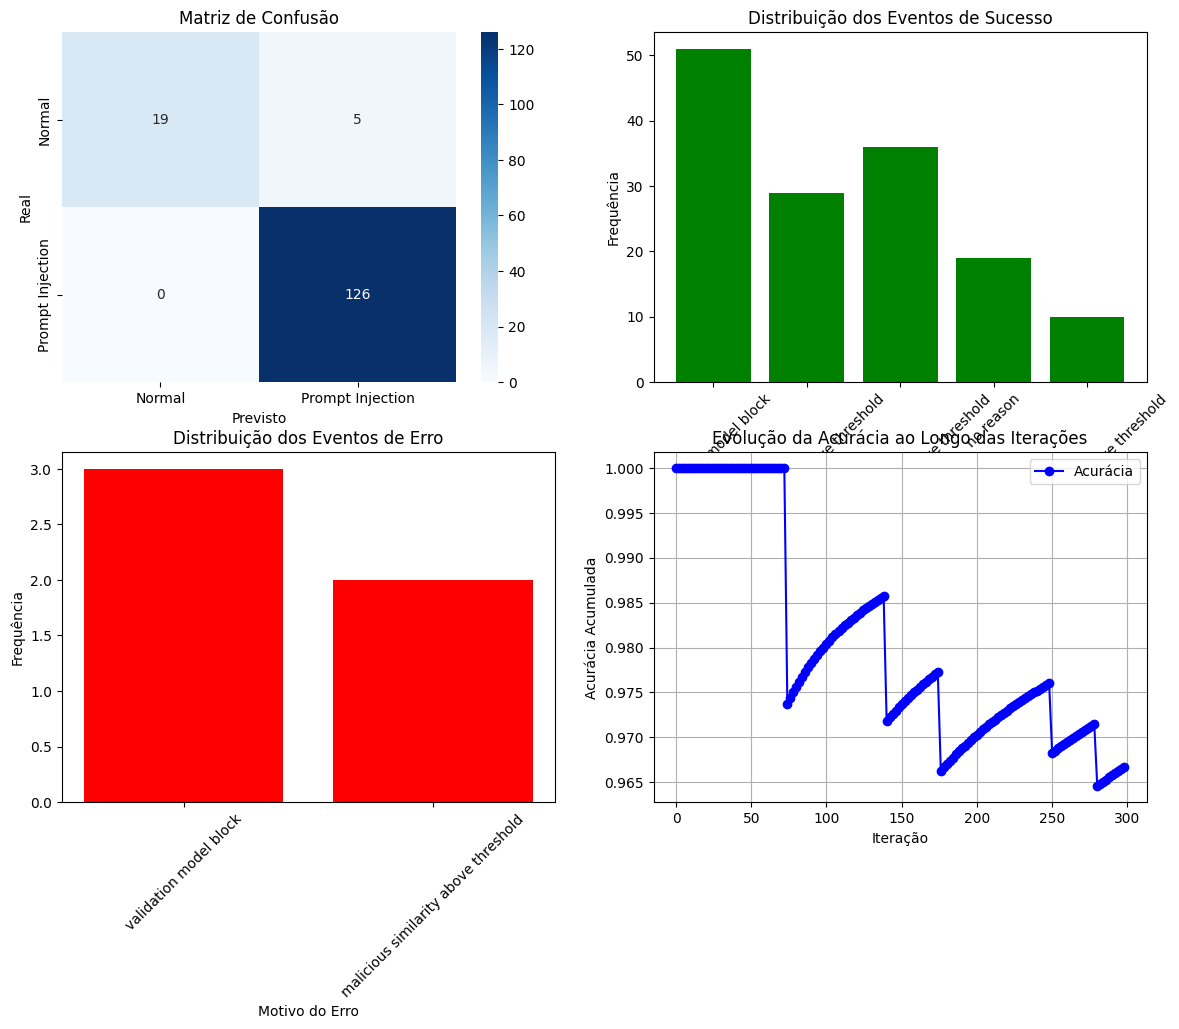

In [12]:
# Criando os gráficos
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Prompt Injection"], yticklabels=["Normal", "Prompt Injection"], ax=axs[0, 0])
axs[0, 0].set_xlabel("Previsto")
axs[0, 0].set_ylabel("Real")
axs[0, 0].set_title("Matriz de Confusão")

# Gráfico de barras para sucess_events
axs[0, 1].bar(success_events.keys(), success_events.values(), color='g')
axs[0, 1].set_xlabel("Motivo do Sucesso")
axs[0, 1].set_ylabel("Frequência")
axs[0, 1].set_title("Distribuição dos Eventos de Sucesso")
axs[0, 1].tick_params(axis='x', rotation=45)

# Gráfico de barras para error_events
axs[1, 0].bar(error_events.keys(), error_events.values(), color='r')
axs[1, 0].set_xlabel("Motivo do Erro")
axs[1, 0].set_ylabel("Frequência")
axs[1, 0].set_title("Distribuição dos Eventos de Erro")
axs[1, 0].tick_params(axis='x', rotation=45)

# Evolução da acurácia ao longo das iterações
rolling_accuracy = np.cumsum(np.array(y_true) == np.array(y_pred)) / (np.arange(1, len(y_true) + 1))

axs[1, 1].plot(iterations, rolling_accuracy, marker='o', linestyle='-', color='b', label='Acurácia')
axs[1, 1].set_xlabel("Iteração")
axs[1, 1].set_ylabel("Acurácia Acumulada")
axs[1, 1].set_title("Evolução da Acurácia ao Longo das Iterações")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.show()

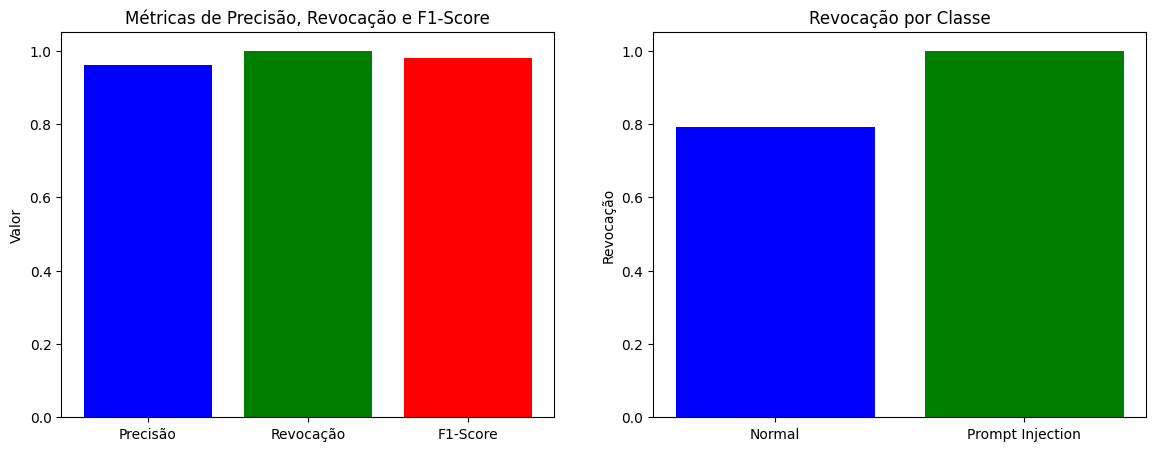

In [13]:
# Crie gráficos de precisão e recall
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras para precisão
axs[0].bar(["Precisão", "Revocação", "F1-Score"], [precision, recall, f1], color=['b', 'g', 'r'])
axs[0].set_ylabel("Valor")
axs[0].set_title("Métricas de Precisão, Revocação e F1-Score")

# Gráfico de barras para recall
axs[1].bar(["Normal", "Prompt Injection"], [recall_score(y_true, y_pred, pos_label=0), recall_score(y_true, y_pred, pos_label=1)], color=['b', 'g'])
axs[1].set_ylabel("Revocação")
axs[1].set_title("Revocação por Classe")

plt.show()
